In [1]:
#%mkdir ComputerVision
%cd ComputerVision

/home/cvmlserver3/jihee/ComputerVision


In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split
import torchvision.datasets as datasets
import time
from tqdm import tqdm
from pytorch_pretrained_vit import ViT
import matplotlib.pyplot as plt

In [3]:
# 데이터 증강 및 정규화 설정
transform_train = transforms.Compose([
    transforms.Resize((224, 224)),  # ViT는 224x224 입력을 기대
    transforms.RandomCrop(224, padding=4),  # RandomCrop 크기 수정
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),  # 정규화 범위 수정
])

transform_test = transforms.Compose([
    transforms.Resize((224, 224)),  # ViT는 224x224 입력을 기대
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),  # 정규화 범위 수정
])

# CIFAR-10 데이터셋 다운로드 및 로더 설정
full_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)

# 전체 데이터를 학습, 검증, 테스트 데이터로 분할
train_size = int(0.8 * len(full_dataset))
val_size = int(0.1 * len(full_dataset))
train_dataset, val_dataset, _ = random_split(full_dataset, [train_size, val_size, len(full_dataset) - train_size - val_size])

trainloader = DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=4)
valloader = DataLoader(val_dataset, batch_size=128, shuffle=False, num_workers=4)
testloader = DataLoader(test_dataset, batch_size=128, shuffle=False, num_workers=4)


Files already downloaded and verified
Files already downloaded and verified


In [4]:
# 사전 학습된 ViT 모델 불러오기
model = ViT('B_16', pretrained=True, image_size=224, patches=4)

# CIFAR-10은 10개의 클래스를 가지므로, 마지막 레이어를 수정
model.fc = nn.Linear(model.fc.in_features, 10)

# 손실 함수 및 옵티마이저 정의
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Multi-GPU 지원을 위해 DataParallel 사용
if torch.cuda.device_count() > 1:
    model = nn.DataParallel(model)

# 모델을 GPU로 이동
device = torch.device("cuda")
model.to(device)

Resized positional embeddings from torch.Size([1, 197, 768]) to torch.Size([1, 197, 768])
Loaded pretrained weights.


DataParallel(
  (module): ViT(
    (patch_embedding): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    (positional_embedding): PositionalEmbedding1D()
    (transformer): Transformer(
      (blocks): ModuleList(
        (0-11): 12 x Block(
          (attn): MultiHeadedSelfAttention(
            (proj_q): Linear(in_features=768, out_features=768, bias=True)
            (proj_k): Linear(in_features=768, out_features=768, bias=True)
            (proj_v): Linear(in_features=768, out_features=768, bias=True)
            (drop): Dropout(p=0.1, inplace=False)
          )
          (proj): Linear(in_features=768, out_features=768, bias=True)
          (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
          (pwff): PositionWiseFeedForward(
            (fc1): Linear(in_features=768, out_features=3072, bias=True)
            (fc2): Linear(in_features=3072, out_features=768, bias=True)
          )
          (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
   

In [5]:
num_epochs = 100
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

for epoch in range(num_epochs):
    start_time = time.time()
    running_loss = 0.0
    correct = 0
    total = 0

    # Training loop
    model.train()
    trainloader_tqdm = tqdm(trainloader, desc=f'Epoch {epoch + 1}/{num_epochs}', unit='batch')
    for data in trainloader_tqdm:
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        # Update tqdm description
        trainloader_tqdm.set_postfix(loss=running_loss / (total / labels.size(0)), accuracy=100 * correct / total)

    train_loss = running_loss / len(trainloader)
    train_accuracy = 100 * correct / total
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)

    # Validation loop
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for data in tqdm(valloader, desc='Validation', unit='batch'):
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    val_loss /= len(valloader)
    val_accuracy = 100 * correct / total
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)

    end_time = time.time()
    epoch_time = end_time - start_time
    remaining_time = epoch_time * (num_epochs - epoch - 1)
    eta = time.strftime("%H:%M:%S", time.gmtime(remaining_time))

    print(f'Epoch [{epoch + 1}/{num_epochs}], '
          f'Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%, '
          f'Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.2f}%, '
          f'ETA: {eta}')
    if epoch % 10 == 0:
        # 모델 저장
        torch.save(model.state_dict(), f'vit_cifar10_{epoch}.pth')
        print(f'saved model at epoch {epoch}')

print('Finished Training')

Validation: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:09<00:00,  4.27batch/s]


Epoch [1/100], Train Loss: 0.7427, Train Accuracy: 75.09%, Val Loss: 0.3732, Val Accuracy: 86.92%, ETA: 04:59:24
saved model at epoch 0


Validation: 100%|████████████████████████████████████| 40/40 [00:09<00:00,  4.36batch/s]


Epoch [2/100], Train Loss: 0.3718, Train Accuracy: 87.54%, Val Loss: 0.3366, Val Accuracy: 88.40%, ETA: 04:55:28


Validation: 100%|████████████████████████████████████| 40/40 [00:09<00:00,  4.31batch/s]


Epoch [3/100], Train Loss: 0.3248, Train Accuracy: 89.11%, Val Loss: 0.3312, Val Accuracy: 88.58%, ETA: 04:52:32


Validation: 100%|████████████████████████████████████| 40/40 [00:09<00:00,  4.28batch/s]


Epoch [4/100], Train Loss: 0.2998, Train Accuracy: 89.86%, Val Loss: 0.3305, Val Accuracy: 89.44%, ETA: 04:49:35


Validation: 100%|████████████████████████████████████| 40/40 [00:09<00:00,  4.26batch/s]


Epoch [5/100], Train Loss: 0.2662, Train Accuracy: 90.90%, Val Loss: 0.3085, Val Accuracy: 89.14%, ETA: 04:47:16


Validation: 100%|████████████████████████████████████| 40/40 [00:09<00:00,  4.33batch/s]


Epoch [6/100], Train Loss: 0.2616, Train Accuracy: 91.00%, Val Loss: 0.2787, Val Accuracy: 91.06%, ETA: 04:44:32


Validation: 100%|████████████████████████████████████| 40/40 [00:09<00:00,  4.35batch/s]


Epoch [7/100], Train Loss: 0.2508, Train Accuracy: 91.44%, Val Loss: 0.3474, Val Accuracy: 88.22%, ETA: 04:40:51


Validation: 100%|████████████████████████████████████| 40/40 [00:09<00:00,  4.33batch/s]


Epoch [8/100], Train Loss: 0.2430, Train Accuracy: 91.84%, Val Loss: 0.3244, Val Accuracy: 89.16%, ETA: 04:37:53


Validation: 100%|████████████████████████████████████| 40/40 [00:09<00:00,  4.31batch/s]


Epoch [9/100], Train Loss: 0.2473, Train Accuracy: 91.55%, Val Loss: 0.3807, Val Accuracy: 87.40%, ETA: 04:34:56


Validation: 100%|████████████████████████████████████| 40/40 [00:09<00:00,  4.24batch/s]


Epoch [10/100], Train Loss: 0.2303, Train Accuracy: 92.05%, Val Loss: 0.2973, Val Accuracy: 90.38%, ETA: 04:32:41


Validation: 100%|████████████████████████████████████| 40/40 [00:09<00:00,  4.33batch/s]


Epoch [11/100], Train Loss: 0.2128, Train Accuracy: 92.65%, Val Loss: 0.2938, Val Accuracy: 90.60%, ETA: 04:28:32
saved model at epoch 10


Validation: 100%|████████████████████████████████████| 40/40 [00:09<00:00,  4.33batch/s]


Epoch [12/100], Train Loss: 0.2103, Train Accuracy: 92.80%, Val Loss: 0.2958, Val Accuracy: 89.96%, ETA: 04:26:02


Validation: 100%|████████████████████████████████████| 40/40 [00:09<00:00,  4.29batch/s]


Epoch [13/100], Train Loss: 0.2116, Train Accuracy: 92.74%, Val Loss: 0.2966, Val Accuracy: 89.68%, ETA: 04:22:27


Validation: 100%|████████████████████████████████████| 40/40 [00:09<00:00,  4.26batch/s]


Epoch [14/100], Train Loss: 0.2012, Train Accuracy: 92.92%, Val Loss: 0.2917, Val Accuracy: 90.04%, ETA: 04:19:50


Validation: 100%|████████████████████████████████████| 40/40 [00:09<00:00,  4.34batch/s]


Epoch [15/100], Train Loss: 0.1913, Train Accuracy: 93.39%, Val Loss: 0.2977, Val Accuracy: 90.22%, ETA: 04:16:37


Validation: 100%|████████████████████████████████████| 40/40 [00:09<00:00,  4.35batch/s]


Epoch [16/100], Train Loss: 0.1678, Train Accuracy: 94.19%, Val Loss: 0.2828, Val Accuracy: 90.66%, ETA: 04:13:54


Validation: 100%|████████████████████████████████████| 40/40 [00:09<00:00,  4.29batch/s]


Epoch [17/100], Train Loss: 0.1519, Train Accuracy: 94.67%, Val Loss: 0.3014, Val Accuracy: 90.54%, ETA: 04:10:22


Validation: 100%|████████████████████████████████████| 40/40 [00:09<00:00,  4.36batch/s]


Epoch [18/100], Train Loss: 0.1582, Train Accuracy: 94.37%, Val Loss: 0.2786, Val Accuracy: 90.84%, ETA: 04:07:53


Validation: 100%|████████████████████████████████████| 40/40 [00:09<00:00,  4.28batch/s]


Epoch [19/100], Train Loss: 0.1600, Train Accuracy: 94.45%, Val Loss: 0.2729, Val Accuracy: 90.98%, ETA: 04:04:54


Validation: 100%|████████████████████████████████████| 40/40 [00:09<00:00,  4.36batch/s]


Epoch [20/100], Train Loss: 0.1583, Train Accuracy: 94.35%, Val Loss: 0.2845, Val Accuracy: 91.46%, ETA: 04:01:40


Validation: 100%|████████████████████████████████████| 40/40 [00:09<00:00,  4.39batch/s]


Epoch [21/100], Train Loss: 0.1465, Train Accuracy: 94.93%, Val Loss: 0.2744, Val Accuracy: 91.34%, ETA: 03:57:47
saved model at epoch 20


Validation: 100%|████████████████████████████████████| 40/40 [00:09<00:00,  4.32batch/s]


Epoch [22/100], Train Loss: 0.1550, Train Accuracy: 94.64%, Val Loss: 0.2926, Val Accuracy: 89.82%, ETA: 03:55:43


Validation: 100%|████████████████████████████████████| 40/40 [00:09<00:00,  4.32batch/s]


Epoch [23/100], Train Loss: 0.1482, Train Accuracy: 94.91%, Val Loss: 0.3092, Val Accuracy: 90.04%, ETA: 03:52:28


Validation: 100%|████████████████████████████████████| 40/40 [00:09<00:00,  4.29batch/s]


Epoch [24/100], Train Loss: 0.1468, Train Accuracy: 94.85%, Val Loss: 0.2936, Val Accuracy: 90.28%, ETA: 03:49:23


Validation: 100%|████████████████████████████████████| 40/40 [00:09<00:00,  4.27batch/s]


Epoch [25/100], Train Loss: 0.1420, Train Accuracy: 95.00%, Val Loss: 0.2979, Val Accuracy: 91.14%, ETA: 03:46:06


Validation: 100%|████████████████████████████████████| 40/40 [00:09<00:00,  4.34batch/s]


Epoch [26/100], Train Loss: 0.1286, Train Accuracy: 95.48%, Val Loss: 0.2899, Val Accuracy: 90.32%, ETA: 03:43:25


Validation: 100%|████████████████████████████████████| 40/40 [00:09<00:00,  4.35batch/s]


Epoch [27/100], Train Loss: 0.1256, Train Accuracy: 95.68%, Val Loss: 0.2794, Val Accuracy: 91.16%, ETA: 03:40:27


Validation: 100%|████████████████████████████████████| 40/40 [00:09<00:00,  4.31batch/s]


Epoch [28/100], Train Loss: 0.1101, Train Accuracy: 96.17%, Val Loss: 0.2973, Val Accuracy: 90.82%, ETA: 03:37:32


Validation: 100%|████████████████████████████████████| 40/40 [00:09<00:00,  4.29batch/s]


Epoch [29/100], Train Loss: 0.1235, Train Accuracy: 95.74%, Val Loss: 0.3008, Val Accuracy: 90.92%, ETA: 03:34:35


Validation: 100%|████████████████████████████████████| 40/40 [00:09<00:00,  4.32batch/s]


Epoch [30/100], Train Loss: 0.1155, Train Accuracy: 96.02%, Val Loss: 0.2786, Val Accuracy: 90.90%, ETA: 03:31:08


Validation: 100%|████████████████████████████████████| 40/40 [00:09<00:00,  4.30batch/s]


Epoch [31/100], Train Loss: 0.1149, Train Accuracy: 96.02%, Val Loss: 0.2741, Val Accuracy: 91.24%, ETA: 03:28:36
saved model at epoch 30


Validation: 100%|████████████████████████████████████| 40/40 [00:09<00:00,  4.32batch/s]


Epoch [32/100], Train Loss: 0.1167, Train Accuracy: 95.88%, Val Loss: 0.3353, Val Accuracy: 90.96%, ETA: 03:25:32


Validation: 100%|████████████████████████████████████| 40/40 [00:09<00:00,  4.32batch/s]


Epoch [33/100], Train Loss: 0.1112, Train Accuracy: 96.18%, Val Loss: 0.3401, Val Accuracy: 89.56%, ETA: 03:22:26


Validation: 100%|████████████████████████████████████| 40/40 [00:09<00:00,  4.32batch/s]


Epoch [34/100], Train Loss: 0.1027, Train Accuracy: 96.45%, Val Loss: 0.2881, Val Accuracy: 91.50%, ETA: 03:19:05


Validation: 100%|████████████████████████████████████| 40/40 [00:09<00:00,  4.33batch/s]


Epoch [35/100], Train Loss: 0.1021, Train Accuracy: 96.48%, Val Loss: 0.2824, Val Accuracy: 91.76%, ETA: 03:16:15


Validation: 100%|████████████████████████████████████| 40/40 [00:09<00:00,  4.38batch/s]


Epoch [36/100], Train Loss: 0.0871, Train Accuracy: 97.02%, Val Loss: 0.2670, Val Accuracy: 91.92%, ETA: 03:13:18


Validation: 100%|████████████████████████████████████| 40/40 [00:09<00:00,  4.29batch/s]


Epoch [37/100], Train Loss: 0.1001, Train Accuracy: 96.48%, Val Loss: 0.3251, Val Accuracy: 90.26%, ETA: 03:10:05


Validation: 100%|████████████████████████████████████| 40/40 [00:09<00:00,  4.31batch/s]


Epoch [38/100], Train Loss: 0.1049, Train Accuracy: 96.30%, Val Loss: 0.2822, Val Accuracy: 91.34%, ETA: 03:07:21


Validation: 100%|████████████████████████████████████| 40/40 [00:09<00:00,  4.28batch/s]


Epoch [39/100], Train Loss: 0.0880, Train Accuracy: 97.01%, Val Loss: 0.3543, Val Accuracy: 89.88%, ETA: 03:04:26


Validation: 100%|████████████████████████████████████| 40/40 [00:09<00:00,  4.35batch/s]


Epoch [40/100], Train Loss: 0.0798, Train Accuracy: 97.30%, Val Loss: 0.3057, Val Accuracy: 90.88%, ETA: 03:01:30


Validation: 100%|████████████████████████████████████| 40/40 [00:09<00:00,  4.35batch/s]


Epoch [41/100], Train Loss: 0.0895, Train Accuracy: 96.84%, Val Loss: 0.2951, Val Accuracy: 90.68%, ETA: 02:58:16
saved model at epoch 40


Validation: 100%|████████████████████████████████████| 40/40 [00:09<00:00,  4.33batch/s]


Epoch [42/100], Train Loss: 0.1093, Train Accuracy: 96.29%, Val Loss: 0.2768, Val Accuracy: 91.66%, ETA: 02:55:02


Validation: 100%|████████████████████████████████████| 40/40 [00:09<00:00,  4.35batch/s]


Epoch [43/100], Train Loss: 0.0881, Train Accuracy: 96.89%, Val Loss: 0.2983, Val Accuracy: 90.88%, ETA: 02:51:51


Validation: 100%|████████████████████████████████████| 40/40 [00:09<00:00,  4.34batch/s]


Epoch [44/100], Train Loss: 0.0945, Train Accuracy: 96.69%, Val Loss: 0.3174, Val Accuracy: 90.30%, ETA: 02:48:48


Validation: 100%|████████████████████████████████████| 40/40 [00:09<00:00,  4.31batch/s]


Epoch [45/100], Train Loss: 0.0933, Train Accuracy: 96.73%, Val Loss: 0.2959, Val Accuracy: 91.48%, ETA: 02:46:13


Validation: 100%|████████████████████████████████████| 40/40 [00:09<00:00,  4.30batch/s]


Epoch [46/100], Train Loss: 0.0853, Train Accuracy: 97.05%, Val Loss: 0.3340, Val Accuracy: 90.72%, ETA: 02:43:07


Validation: 100%|████████████████████████████████████| 40/40 [00:09<00:00,  4.31batch/s]


Epoch [47/100], Train Loss: 0.0935, Train Accuracy: 96.81%, Val Loss: 0.3178, Val Accuracy: 89.98%, ETA: 02:39:49


Validation: 100%|████████████████████████████████████| 40/40 [00:09<00:00,  4.29batch/s]


Epoch [48/100], Train Loss: 0.0882, Train Accuracy: 96.97%, Val Loss: 0.3065, Val Accuracy: 91.52%, ETA: 02:37:14


Validation: 100%|████████████████████████████████████| 40/40 [00:09<00:00,  4.34batch/s]


Epoch [49/100], Train Loss: 0.0845, Train Accuracy: 97.00%, Val Loss: 0.3628, Val Accuracy: 89.32%, ETA: 02:33:57


Validation: 100%|████████████████████████████████████| 40/40 [00:09<00:00,  4.32batch/s]


Epoch [50/100], Train Loss: 0.0832, Train Accuracy: 97.12%, Val Loss: 0.3487, Val Accuracy: 90.22%, ETA: 02:30:38


Validation: 100%|████████████████████████████████████| 40/40 [00:09<00:00,  4.32batch/s]


Epoch [51/100], Train Loss: 0.0806, Train Accuracy: 97.23%, Val Loss: 0.2917, Val Accuracy: 91.86%, ETA: 02:27:38
saved model at epoch 50


Validation: 100%|████████████████████████████████████| 40/40 [00:09<00:00,  4.36batch/s]


Epoch [52/100], Train Loss: 0.0779, Train Accuracy: 97.28%, Val Loss: 0.3034, Val Accuracy: 91.10%, ETA: 02:24:42


Validation: 100%|████████████████████████████████████| 40/40 [00:09<00:00,  4.26batch/s]


Epoch [53/100], Train Loss: 0.0970, Train Accuracy: 96.62%, Val Loss: 0.3204, Val Accuracy: 90.30%, ETA: 02:21:53


Validation: 100%|████████████████████████████████████| 40/40 [00:09<00:00,  4.37batch/s]


Epoch [54/100], Train Loss: 0.0889, Train Accuracy: 97.02%, Val Loss: 0.2883, Val Accuracy: 91.26%, ETA: 02:18:45


Validation: 100%|████████████████████████████████████| 40/40 [00:09<00:00,  4.35batch/s]


Epoch [55/100], Train Loss: 0.0752, Train Accuracy: 97.34%, Val Loss: 0.3175, Val Accuracy: 90.50%, ETA: 02:15:45


Validation: 100%|████████████████████████████████████| 40/40 [00:09<00:00,  4.35batch/s]


Epoch [56/100], Train Loss: 0.0781, Train Accuracy: 97.34%, Val Loss: 0.2805, Val Accuracy: 91.78%, ETA: 02:12:29


Validation: 100%|████████████████████████████████████| 40/40 [00:09<00:00,  4.37batch/s]


Epoch [57/100], Train Loss: 0.0660, Train Accuracy: 97.74%, Val Loss: 0.2738, Val Accuracy: 92.12%, ETA: 02:09:27


Validation: 100%|████████████████████████████████████| 40/40 [00:09<00:00,  4.30batch/s]


Epoch [58/100], Train Loss: 0.0665, Train Accuracy: 97.72%, Val Loss: 0.3034, Val Accuracy: 91.46%, ETA: 02:06:48


Validation: 100%|████████████████████████████████████| 40/40 [00:09<00:00,  4.38batch/s]


Epoch [59/100], Train Loss: 0.0623, Train Accuracy: 97.84%, Val Loss: 0.2940, Val Accuracy: 91.50%, ETA: 02:03:49


Validation: 100%|████████████████████████████████████| 40/40 [00:09<00:00,  4.31batch/s]


Epoch [60/100], Train Loss: 0.0676, Train Accuracy: 97.64%, Val Loss: 0.2899, Val Accuracy: 91.70%, ETA: 02:01:00


Validation: 100%|████████████████████████████████████| 40/40 [00:09<00:00,  4.27batch/s]


Epoch [61/100], Train Loss: 0.0831, Train Accuracy: 97.23%, Val Loss: 0.3330, Val Accuracy: 90.14%, ETA: 01:57:34
saved model at epoch 60


Validation: 100%|████████████████████████████████████| 40/40 [00:09<00:00,  4.27batch/s]


Epoch [62/100], Train Loss: 0.0893, Train Accuracy: 96.90%, Val Loss: 0.3048, Val Accuracy: 91.40%, ETA: 01:54:48


Validation: 100%|████████████████████████████████████| 40/40 [00:09<00:00,  4.27batch/s]


Epoch [63/100], Train Loss: 0.0868, Train Accuracy: 97.02%, Val Loss: 0.2755, Val Accuracy: 92.26%, ETA: 01:51:56


Validation: 100%|████████████████████████████████████| 40/40 [00:09<00:00,  4.29batch/s]


Epoch [64/100], Train Loss: 0.0679, Train Accuracy: 97.66%, Val Loss: 0.3753, Val Accuracy: 88.68%, ETA: 01:48:46


Validation: 100%|████████████████████████████████████| 40/40 [00:09<00:00,  4.34batch/s]


Epoch [65/100], Train Loss: 0.0766, Train Accuracy: 97.49%, Val Loss: 0.3248, Val Accuracy: 91.26%, ETA: 01:45:54


Validation: 100%|████████████████████████████████████| 40/40 [00:09<00:00,  4.37batch/s]


Epoch [66/100], Train Loss: 0.0667, Train Accuracy: 97.72%, Val Loss: 0.2908, Val Accuracy: 91.82%, ETA: 01:42:38


Validation: 100%|████████████████████████████████████| 40/40 [00:09<00:00,  4.27batch/s]


Epoch [67/100], Train Loss: 0.0677, Train Accuracy: 97.62%, Val Loss: 0.3001, Val Accuracy: 91.44%, ETA: 01:39:52


Validation: 100%|████████████████████████████████████| 40/40 [00:09<00:00,  4.34batch/s]


Epoch [68/100], Train Loss: 0.0872, Train Accuracy: 97.00%, Val Loss: 0.3301, Val Accuracy: 89.50%, ETA: 01:36:31


Validation: 100%|████████████████████████████████████| 40/40 [00:09<00:00,  4.28batch/s]


Epoch [69/100], Train Loss: 0.1038, Train Accuracy: 96.39%, Val Loss: 0.3254, Val Accuracy: 90.34%, ETA: 01:33:38


Validation: 100%|████████████████████████████████████| 40/40 [00:09<00:00,  4.31batch/s]


Epoch [70/100], Train Loss: 0.0752, Train Accuracy: 97.36%, Val Loss: 0.2931, Val Accuracy: 91.94%, ETA: 01:30:41


Validation: 100%|████████████████████████████████████| 40/40 [00:09<00:00,  4.33batch/s]


Epoch [71/100], Train Loss: 0.0705, Train Accuracy: 97.56%, Val Loss: 0.2936, Val Accuracy: 91.48%, ETA: 01:27:42
saved model at epoch 70


Validation: 100%|████████████████████████████████████| 40/40 [00:09<00:00,  4.29batch/s]


Epoch [72/100], Train Loss: 0.0552, Train Accuracy: 98.08%, Val Loss: 0.2814, Val Accuracy: 92.30%, ETA: 01:24:40


Validation: 100%|████████████████████████████████████| 40/40 [00:09<00:00,  4.30batch/s]


Epoch [73/100], Train Loss: 0.0612, Train Accuracy: 97.90%, Val Loss: 0.3502, Val Accuracy: 90.12%, ETA: 01:21:45


Validation: 100%|████████████████████████████████████| 40/40 [00:09<00:00,  4.32batch/s]


Epoch [74/100], Train Loss: 0.0689, Train Accuracy: 97.61%, Val Loss: 0.3347, Val Accuracy: 90.70%, ETA: 01:18:41


Validation: 100%|████████████████████████████████████| 40/40 [00:09<00:00,  4.27batch/s]


Epoch [75/100], Train Loss: 0.0911, Train Accuracy: 96.86%, Val Loss: 0.3810, Val Accuracy: 89.92%, ETA: 01:15:32


Validation: 100%|████████████████████████████████████| 40/40 [00:09<00:00,  4.33batch/s]


Epoch [76/100], Train Loss: 0.0913, Train Accuracy: 96.85%, Val Loss: 0.3810, Val Accuracy: 90.04%, ETA: 01:12:35


Validation: 100%|████████████████████████████████████| 40/40 [00:09<00:00,  4.32batch/s]


Epoch [77/100], Train Loss: 0.1045, Train Accuracy: 96.43%, Val Loss: 0.3455, Val Accuracy: 90.30%, ETA: 01:09:28


Validation: 100%|████████████████████████████████████| 40/40 [00:09<00:00,  4.33batch/s]


Epoch [78/100], Train Loss: 0.1323, Train Accuracy: 95.53%, Val Loss: 0.3225, Val Accuracy: 90.18%, ETA: 01:06:29


Validation: 100%|████████████████████████████████████| 40/40 [00:09<00:00,  4.26batch/s]


Epoch [79/100], Train Loss: 0.1619, Train Accuracy: 94.29%, Val Loss: 0.3417, Val Accuracy: 90.30%, ETA: 01:03:29


Validation: 100%|████████████████████████████████████| 40/40 [00:09<00:00,  4.34batch/s]


Epoch [80/100], Train Loss: 0.1903, Train Accuracy: 93.47%, Val Loss: 0.4154, Val Accuracy: 86.74%, ETA: 01:00:21


Validation: 100%|████████████████████████████████████| 40/40 [00:09<00:00,  4.27batch/s]


Epoch [81/100], Train Loss: 0.1641, Train Accuracy: 94.34%, Val Loss: 0.4144, Val Accuracy: 87.00%, ETA: 00:57:28
saved model at epoch 80


Validation: 100%|████████████████████████████████████| 40/40 [00:09<00:00,  4.31batch/s]


Epoch [82/100], Train Loss: 0.2785, Train Accuracy: 90.48%, Val Loss: 0.3467, Val Accuracy: 89.12%, ETA: 00:54:23


Validation: 100%|████████████████████████████████████| 40/40 [00:09<00:00,  4.34batch/s]


Epoch [83/100], Train Loss: 0.1816, Train Accuracy: 93.65%, Val Loss: 0.3376, Val Accuracy: 89.16%, ETA: 00:51:21


Validation: 100%|████████████████████████████████████| 40/40 [00:09<00:00,  4.30batch/s]


Epoch [84/100], Train Loss: 0.1832, Train Accuracy: 93.69%, Val Loss: 0.3452, Val Accuracy: 89.06%, ETA: 00:48:17


Validation: 100%|████████████████████████████████████| 40/40 [00:09<00:00,  4.35batch/s]


Epoch [85/100], Train Loss: 0.1622, Train Accuracy: 94.31%, Val Loss: 0.3791, Val Accuracy: 88.68%, ETA: 00:45:20


Validation: 100%|████████████████████████████████████| 40/40 [00:09<00:00,  4.34batch/s]


Epoch [86/100], Train Loss: 0.1555, Train Accuracy: 94.55%, Val Loss: 0.3371, Val Accuracy: 89.74%, ETA: 00:42:14


Validation: 100%|████████████████████████████████████| 40/40 [00:09<00:00,  4.26batch/s]


Epoch [87/100], Train Loss: 0.1052, Train Accuracy: 96.25%, Val Loss: 0.2967, Val Accuracy: 91.22%, ETA: 00:39:17


Validation: 100%|████████████████████████████████████| 40/40 [00:09<00:00,  4.34batch/s]


Epoch [88/100], Train Loss: 0.1205, Train Accuracy: 95.79%, Val Loss: 0.3992, Val Accuracy: 87.50%, ETA: 00:36:17


Validation: 100%|████████████████████████████████████| 40/40 [00:09<00:00,  4.30batch/s]


Epoch [89/100], Train Loss: 0.2394, Train Accuracy: 91.62%, Val Loss: 0.3916, Val Accuracy: 88.00%, ETA: 00:33:15


Validation: 100%|████████████████████████████████████| 40/40 [00:09<00:00,  4.32batch/s]


Epoch [90/100], Train Loss: 0.1467, Train Accuracy: 94.92%, Val Loss: 0.3708, Val Accuracy: 88.32%, ETA: 00:30:14


Validation: 100%|████████████████████████████████████| 40/40 [00:09<00:00,  4.29batch/s]


Epoch [91/100], Train Loss: 0.1681, Train Accuracy: 94.02%, Val Loss: 0.2998, Val Accuracy: 90.96%, ETA: 00:27:11
saved model at epoch 90


Validation: 100%|████████████████████████████████████| 40/40 [00:09<00:00,  4.31batch/s]


Epoch [92/100], Train Loss: 0.1345, Train Accuracy: 95.33%, Val Loss: 0.4263, Val Accuracy: 86.52%, ETA: 00:24:06


Validation: 100%|████████████████████████████████████| 40/40 [00:09<00:00,  4.30batch/s]


Epoch [93/100], Train Loss: 0.1702, Train Accuracy: 94.00%, Val Loss: 0.3892, Val Accuracy: 86.90%, ETA: 00:21:12


Validation: 100%|████████████████████████████████████| 40/40 [00:09<00:00,  4.27batch/s]


Epoch [94/100], Train Loss: 0.3655, Train Accuracy: 87.30%, Val Loss: 0.4352, Val Accuracy: 84.94%, ETA: 00:18:07


Validation: 100%|████████████████████████████████████| 40/40 [00:09<00:00,  4.32batch/s]


Epoch [95/100], Train Loss: 0.2021, Train Accuracy: 92.96%, Val Loss: 0.3262, Val Accuracy: 89.72%, ETA: 00:15:03


Validation: 100%|████████████████████████████████████| 40/40 [00:09<00:00,  4.28batch/s]


Epoch [96/100], Train Loss: 0.2249, Train Accuracy: 92.16%, Val Loss: 0.3381, Val Accuracy: 88.90%, ETA: 00:12:05


Validation: 100%|████████████████████████████████████| 40/40 [00:09<00:00,  4.29batch/s]


Epoch [97/100], Train Loss: 0.5399, Train Accuracy: 81.33%, Val Loss: 0.5779, Val Accuracy: 80.30%, ETA: 00:09:03


Validation: 100%|████████████████████████████████████| 40/40 [00:09<00:00,  4.26batch/s]


Epoch [98/100], Train Loss: 0.6909, Train Accuracy: 75.69%, Val Loss: 0.9627, Val Accuracy: 67.52%, ETA: 00:06:02


Validation: 100%|████████████████████████████████████| 40/40 [00:09<00:00,  4.30batch/s]


Epoch [99/100], Train Loss: 0.4162, Train Accuracy: 85.21%, Val Loss: 0.3921, Val Accuracy: 87.04%, ETA: 00:03:01


Validation: 100%|████████████████████████████████████| 40/40 [00:09<00:00,  4.36batch/s]

Epoch [100/100], Train Loss: 0.2066, Train Accuracy: 92.72%, Val Loss: 0.3646, Val Accuracy: 87.84%, ETA: 00:00:00
Finished Training


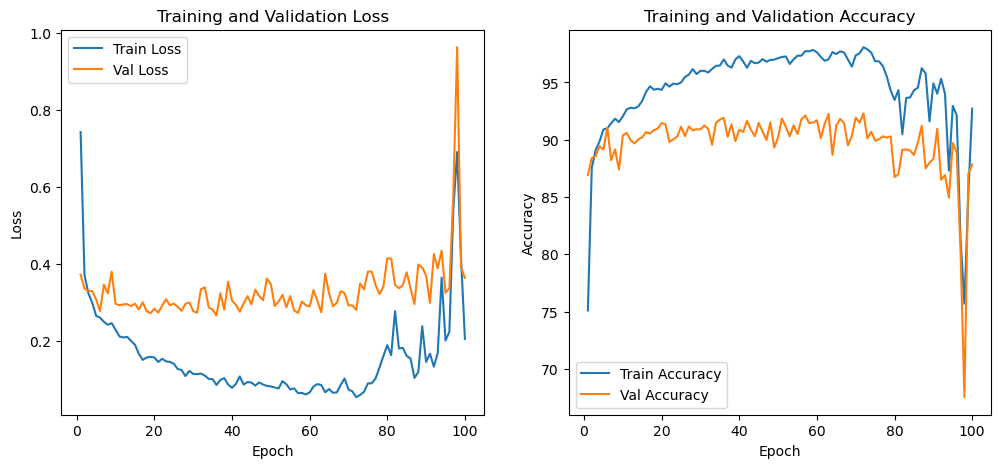

In [6]:
# 모델 저장
torch.save(model.state_dict(), 'vit_cifar10_11th_val.pth')

# 학습 곡선 시각화
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs + 1), train_losses, label='Train Loss')
plt.plot(range(1, num_epochs + 1), val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs + 1), train_accuracies, label='Train Accuracy')
plt.plot(range(1, num_epochs + 1), val_accuracies, label='Val Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.show()

In [7]:
model.eval()
running_test_loss = 0.0
running_test_correct = 0
total_test = 0

with torch.no_grad():
    for inputs, labels in testloader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        
        running_test_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        running_test_correct += (preds == labels).sum().item()
        total_test += labels.size(0)

test_loss = running_test_loss / total_test
test_accuracy = running_test_correct / total_test

print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")

Test Loss: 0.0030, Test Accuracy: 0.8775
